# Project Assignment 3: Amazon Review Classification System (Custom Implementation)

**Name/Group ID:** Berke Yusuf Uğurlu - Yusuf İpek (Group 6)

**Date:** April 25, 2025

**Course:** BBM 409 - Machine Learning Laboratory

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import math
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# splitting allowed
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# load data
reviews_df = pd.read_csv('amazon_reviews.csv')

# display 
print("Sample of the dataset:")
reviews_df.head()

Sample of the dataset:


,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


In [3]:
# basics about the dataset
print("Dataset shape:", reviews_df.shape)
print("\nColumn names:", reviews_df.columns.tolist())

print("\nData types:")
reviews_df.info()

print("\nMissing values:")
print(reviews_df.isnull().sum())

Dataset shape: (72500, 3)

Column names: ['Title', 'Content', 'Star']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB

Missing values:
Title      20
Content     7
Star        0
dtype: int64


## 2.1 Handle Missing Values

Before proceeding with the analysis, we should properly handle any missing values in the dataset.

In [4]:
# missing values handling
print("Missing values before handling:")
missing_values = reviews_df.isnull().sum()
print(missing_values)

reviews_df['Title'] = reviews_df['Title'].fillna("No Title")
reviews_df['Content'] = reviews_df['Content'].fillna("No Content")

print("\nMissing values after handling:")
print(reviews_df.isnull().sum())

Missing values before handling:
Title      20
Content     7
Star        0
dtype: int64

Missing values after handling:
Title      0
Content    0
Star       0
dtype: int64

Example of previously missing value now filled:
         Title     Content  Star
3575  No Title  No Content   3.0
         Title     Content  Star
3575  No Title  No Content   3.0


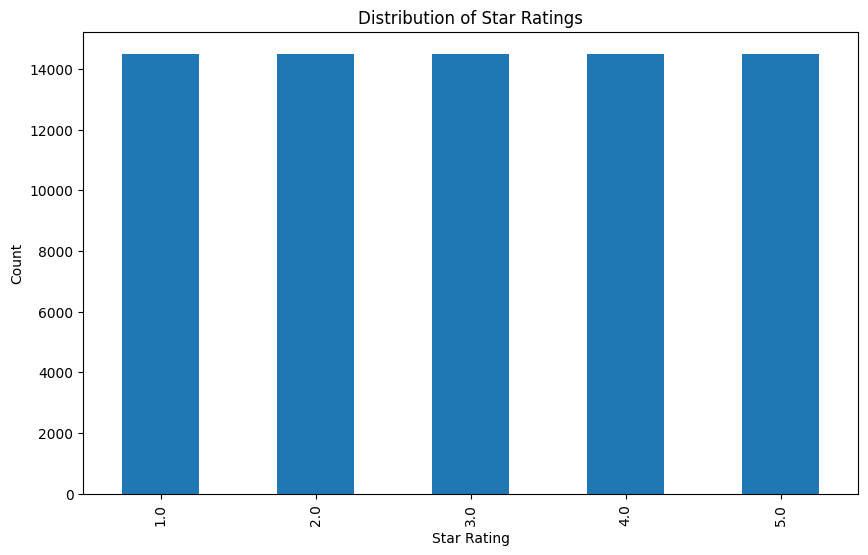

Star rating distribution:
 Star
1.0    14500
2.0    14500
3.0    14500
4.0    14500
5.0    14500
Name: count, dtype: int64


In [5]:
# show distribution of star ratings
plt.figure(figsize=(10, 6))
reviews_df['Star'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

print("Star rating distribution:\n", reviews_df['Star'].value_counts().sort_index())

## 3. Convert to Binary Classification

Convert the multi-class star ratings into a binary classification problem:
- Negative reviews (0): 1-2 stars
- Positive reviews (1): 4-5 stars

Exclude 3-star (neutral) reviews.

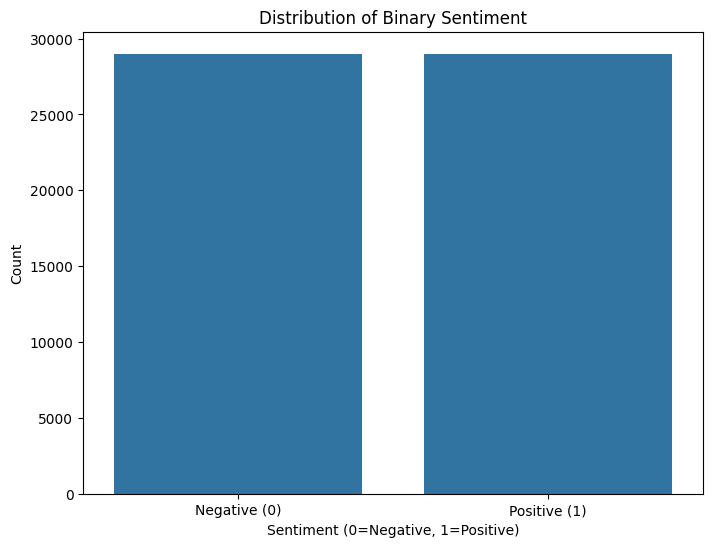

Binary sentiment distribution:
sentiment
0    29000
1    29000
Name: count, dtype: int64


In [6]:
# 0 for negative (1-2 stars), 1 for positive (4-5 stars), none for neutral (3)
reviews_df['sentiment'] = reviews_df['Star'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))
binary_df = reviews_df.dropna(subset=['sentiment']).copy() # remove neutrals
binary_df['sentiment'] = binary_df['sentiment'].astype(int)

# show plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=binary_df)
plt.title('Distribution of Binary Sentiment')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

print("Binary sentiment distribution:")
print(binary_df['sentiment'].value_counts())

## 4. Custom Text Preprocessing

Implement a basic text preprocessing function without using external NLP libraries.

In [7]:
# -- Preprocces Text --
# to lowercase
# remove non-alphanumeric chars
# remove digits
# remove stop words
# split into tokens

STOPWORDS = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", 
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "one"
]

stopwords_pattern = r'\b(' + '|'.join(STOPWORDS) + r')\b'
non_alpha_pattern = r'[^a-z\s]'
digits_pattern = r'\d+'
whitespace_pattern = r'\s+'


def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    text = text.lower()
    text = re.sub(non_alpha_pattern, '', text)
    text = re.sub(digits_pattern, '', text)
    text = re.sub(stopwords_pattern, '', text)
    text = re.sub(whitespace_pattern, ' ', text).strip()
    
    # split to tokens
    tokens = text.split()
    
    # get token with length > 1 
    tokens = [token for token in tokens if len(token) > 1]
    
    return tokens

In [8]:
print("Applying custom text preprocessing...")

binary_df['full_text'] = binary_df['Title'] + " " + binary_df['Content'] # combine title and content
binary_df['tokens'] = binary_df['full_text'].apply(preprocess_text)

# token count column for analysis
binary_df['token_count'] = binary_df['tokens'].apply(len)

# a sample of preprocessed text
print("\nSample of preprocessed text (tokens):")
sample = binary_df[['full_text', 'tokens', 'token_count']].head(3)
pd.set_option('display.max_colwidth', 200)
print(sample)

Applying custom text preprocessing...

Sample of preprocessed text (tokens):
                                                                                                                                                                                            full_text  \
0                                                                                                                                                              Didn't work No change in nails at all.   
1  Worst nail product I have ever used. Garbage! Do not waste your $$$. My nails were worse after using this product for two weeks.  Pathetic!  Going back to my Vaseline Healthy Hand and and Nails.   
2                                                                                                                                                            Just didn't work Nails are still brittle   

                                                                                                                      

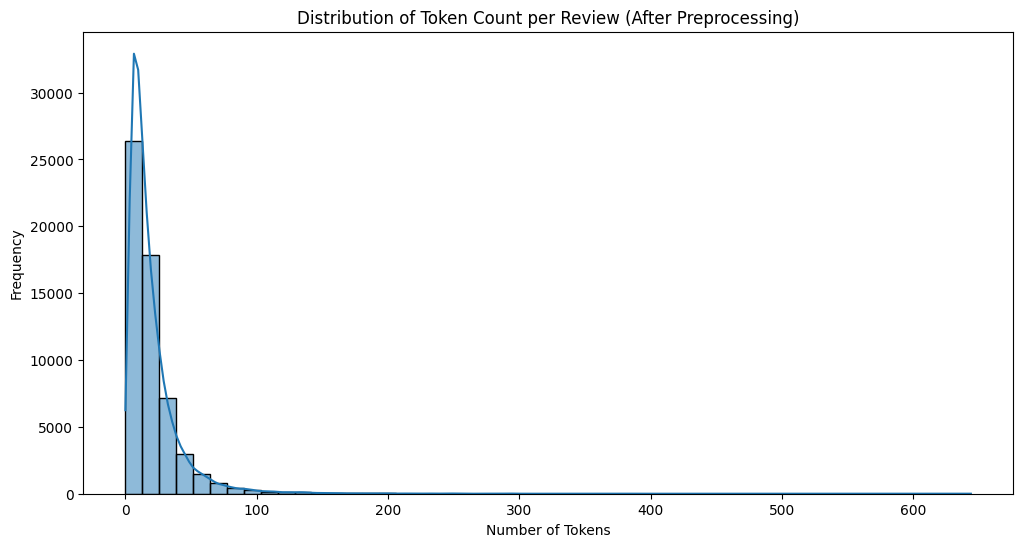


Token count summary statistics:
count    58000.000000
mean        20.077345
std         21.852281
min          0.000000
25%          8.000000
50%         14.000000
75%         25.000000
max        644.000000
Name: token_count, dtype: float64


In [9]:
# token count distribution
plt.figure(figsize=(12, 6))
sns.histplot(binary_df['token_count'], bins=50, kde=True)
plt.title('Distribution of Token Count per Review (After Preprocessing)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

print("\nToken count summary statistics:")
print(binary_df['token_count'].describe())

## Exploratory Data Analysis - Word Frequency

Visualize the most common words in positive and negative reviews using word clouds.

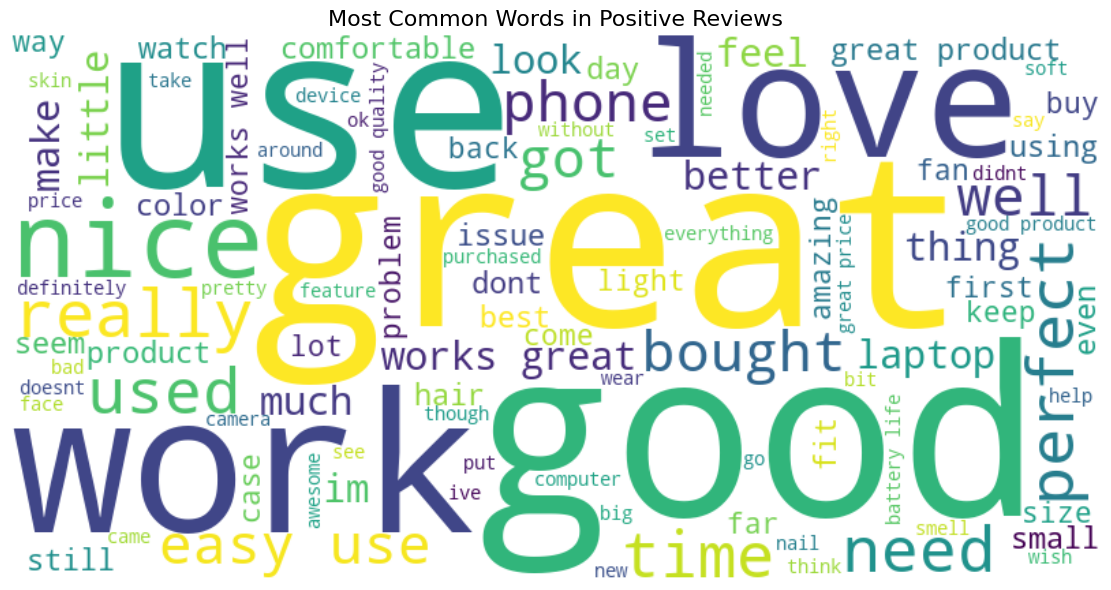

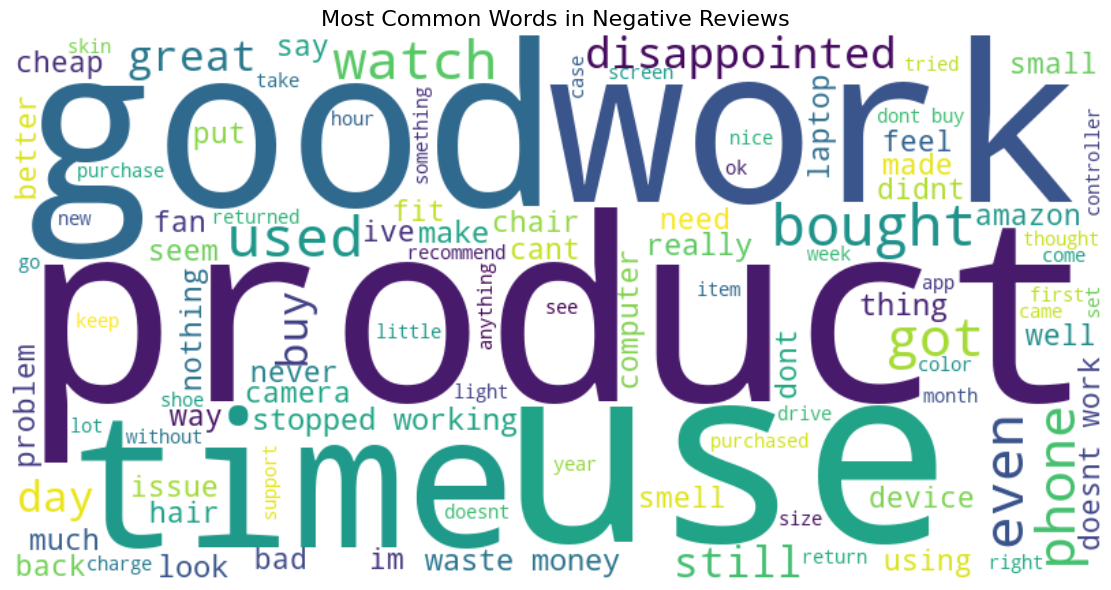

In [10]:
# Function to create a word cloud from tokens
def generate_wordcloud(tokens_list, title):
    # combine tokens to single text
    text = ' '.join([' '.join(tokens) for tokens in tokens_list])
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

positive_tokens = binary_df[binary_df['sentiment'] == 1]['tokens']
negative_tokens = binary_df[binary_df['sentiment'] == 0]['tokens']

generate_wordcloud(positive_tokens, 'Most Common Words in Positive Reviews')
generate_wordcloud(negative_tokens, 'Most Common Words in Negative Reviews')


## Token Distribution by Sentiment

Compare the distribution of token counts between positive and negative reviews.

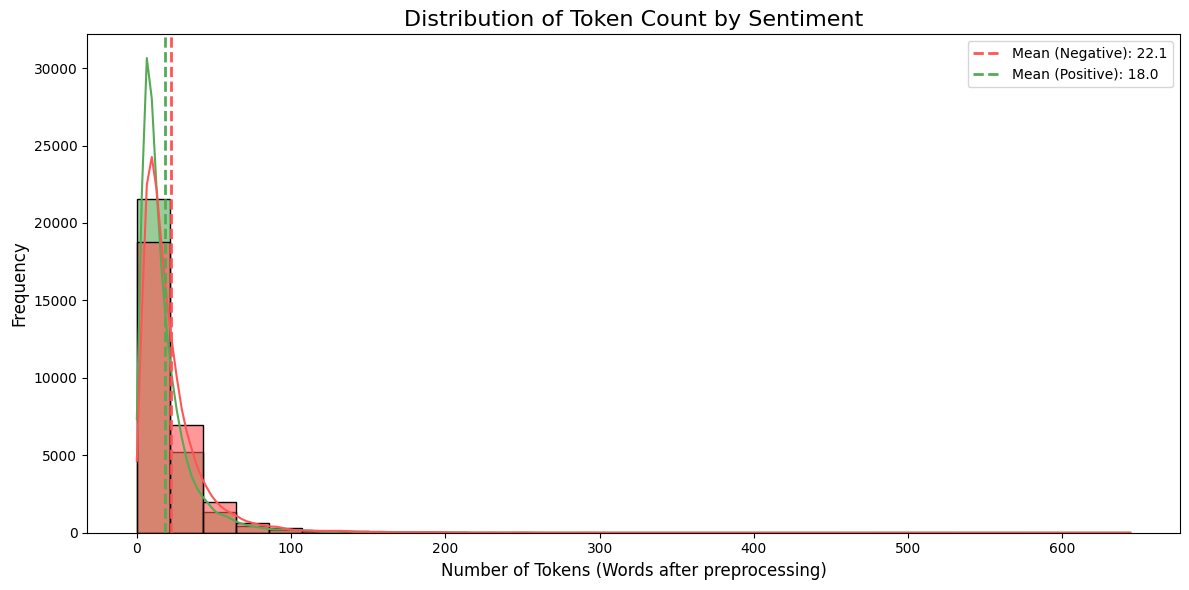

Average token count in negative reviews: 22.11
Average token count in positive reviews: 18.04


In [11]:
# compare token count distribution by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=binary_df, x='token_count', hue='sentiment', bins=30, kde=True, palette=['#FF5555', '#55AA55'], alpha=0.6)

plt.title('Distribution of Token Count by Sentiment', fontsize=16)
plt.xlabel('Number of Tokens (Words after preprocessing)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(labels=['Negative Reviews', 'Positive Reviews'])

# vertical lines for means
mean_neg = binary_df[binary_df['sentiment'] == 0]['token_count'].mean()
mean_pos = binary_df[binary_df['sentiment'] == 1]['token_count'].mean()

plt.axvline(x=mean_neg, color='#FF5555', linestyle='--', linewidth=2, label=f'Mean (Negative): {mean_neg:.1f}')
plt.axvline(x=mean_pos, color='#55AA55', linestyle='--', linewidth=2, label=f'Mean (Positive): {mean_pos:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Average token count in negative reviews: {mean_neg:.2f}")
print(f"Average token count in positive reviews: {mean_pos:.2f}")

## 5. Custom Bag-of-Words (BoW) Implementation

Implement BoW feature extraction from scratch, including vocabulary building and handling n-grams.

In [12]:
# -- Build Vocabulary --

def build_vocabulary(token_lists, min_freq=2):
    word_counts = Counter()
    for tokens in token_lists:
        word_counts.update(tokens)
    
    # Filter words based on minimum frequency
    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    print(f"Built vocabulary with {len(vocab)} words (min_freq={min_freq}). Original unique words: {len(word_counts)}")
    return vocab

In [13]:
# -- Get NGRAMS --

def get_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append("_".join(tokens[i:i+n])) # join n-grams with underscore
    return ngrams

In [14]:
# -- Text to BoW (Bag of Words)
# convert tokens to bow representation

def text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=False):
    bow = Counter()
    features_to_count = []
    
    if use_unigrams:
        features_to_count.extend(tokens)
        
    if use_bigrams:
        features_to_count.extend(get_ngrams(tokens, 2))

    for feature in features_to_count:
        if feature in vocab:
            bow[feature] += 1
            
    return bow

## 6. Data Splitting

In [15]:
# X contains the lists of tokens, y contains the sentiment labels
X = binary_df['tokens'] 
y = binary_df['sentiment']

# 80% train, 20% test
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train_tokens)}")
print(f"Testing set size: {len(X_test_tokens)}")
print(f"Training labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing labels distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: 46400
Testing set size: 11600
Training labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64
Testing labels distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


## 7. Build Vocabulary and Create BoW Features

Build the vocabulary *only* from the training data to avoid data leakage. Then, transform both training and test sets into BoW representations.

In [16]:
print("\n--- Processing Unigrams ---")
unigram_vocab = build_vocabulary(X_train_tokens, min_freq=3)

# unigram BoW for training and test sets
X_train_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_train_tokens]
X_test_bow_uni = [text_to_bow(tokens, unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_test_tokens]

print("\n--- Processing Bigrams ---")
train_features_bi = []
for tokens in X_train_tokens:
    train_features_bi.extend(tokens)
    train_features_bi.extend(get_ngrams(tokens, 2))

bigram_vocab = build_vocabulary([train_features_bi], min_freq=5) # higher min_freq for combined features

# combined unigram+bigram BoW for training and test sets
X_train_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_train_tokens]
X_test_bow_bi = [text_to_bow(tokens, bigram_vocab, use_unigrams=True, use_bigrams=True) for tokens in X_test_tokens]

print("\nSample Unigram BoW vector (first training instance):")
print(list(X_train_bow_uni[0].items())[:10])
print("\nSample Bigram BoW vector (first training instance):")
print(list(X_train_bow_bi[0].items())[:10])


--- Processing Unigrams ---
Built vocabulary with 10995 words (min_freq=3). Original unique words: 33595

--- Processing Bigrams ---
Built vocabulary with 30426 words (min_freq=5). Original unique words: 525738

Sample Unigram BoW vector (first training instance):
[('smell', 2), ('smells', 1), ('good', 1), ('bit', 1), ('strong', 1), ('dont', 1), ('spray', 1), ('much', 1), ('try', 1), ('spraying', 1)]

Sample Bigram BoW vector (first training instance):
[('smell', 2), ('smells', 1), ('good', 1), ('bit', 1), ('strong', 1), ('dont', 1), ('spray', 1), ('much', 1), ('try', 1), ('spraying', 1)]


## 8. Custom Naive Bayes Implementation

Implement the Multinomial Naive Bayes algorithm from scratch using logarithmic probabilities and Laplace smoothing.

In [17]:
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.vocab = set()
        self.log_priors = {} # log P(class)
        self.log_likelihoods = defaultdict(lambda: defaultdict(float)) # log P(word|class)
        self.classes = []
        self.vocab_size = 0
        self.log_likelihood_unknown = {} # log P(unknown|class)

    # train 
    def fit(self, X_bow, y, vocab):
        self.vocab = vocab
        self.vocab_size = len(self.vocab)
        n_docs = len(X_bow)
        self.classes = sorted(list(y.unique()))
        
        # log priors: log P(class) = log(N_class / N_total)
        class_counts = Counter(y)
        for c in self.classes:
            self.log_priors[c] = math.log(class_counts[c] / n_docs)
            
        word_counts_per_class = defaultdict(Counter)
        total_words_per_class = defaultdict(float)
        
        for bow, label in zip(X_bow, y):
            word_counts_per_class[label].update(bow)
            total_words_per_class[label] += sum(bow.values())
            
        # log likelihoods: log P(word|class)
        # by laplace smoothing: log((count(word, class) + alpha) / (total_words_class + alpha * vocab_size))
        for c in self.classes:
            denominator = total_words_per_class[c] + self.alpha * self.vocab_size
            # known words
            for word in self.vocab:
                numerator = word_counts_per_class[c][word] + self.alpha
                self.log_likelihoods[c][word] = math.log(numerator / denominator)
            
            # unknown words in prediction - not in vocab
            # P(unknown|class) = alpha / (total_words_class + alpha * vocab_size)
            self.log_likelihood_unknown[c] = math.log(self.alpha / denominator)
            
        print("Naive Bayes training complete.")
        print(f"Log Priors: {self.log_priors}")
        print(f"Log Likelihood for Unknown Words: {self.log_likelihood_unknown}")

    # Prediction
    def predict(self, X_bow):
        predictions = []
        for bow in X_bow:
            class_scores = {}
            for c in self.classes:
                score = self.log_priors[c]
                for word, count in bow.items():
                    if word in self.vocab:
                        score += count * self.log_likelihoods[c][word]
                    else:
                        # handle unknown words
                        score += count * self.log_likelihood_unknown[c]
                class_scores[c] = score
            
            # get highest log probability
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
            
        return predictions

## 9. Model Training and Evaluation (Custom Implementation)

### Performance Metrics and Confusion Matrices Visualization

Calculate Metrics by formula
<br/><br/>
**Confusion Matrix Structure:**
|                      | Predicted Positive | Predicted Negative |
|----------------------|--------------------|--------------------|
| **Actual Positive**  | True Positive (TP) | False Negative (FN)|
| **Actual Negative**  | False Positive (FP)| True Negative (TN) |


**Metrics Formulas:**
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

In [18]:
# -- Calculate Accuracy --
def calculate_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return (correct / len(y_true) if len(y_true) > 0 else 0) * 100

In [19]:
# -- Calculate Precision --
def calculate_precision(y_true, y_pred):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt != 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    return (tp / (tp + fp) if (tp + fp) > 0 else 0) * 100

In [20]:
# -- Calculate Recall --
def calculate_recall(y_true, y_pred):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp != 1) for yt, yp in zip(y_true, y_pred))
    return (tp / (tp + fn) if (tp + fn) > 0 else 0) * 100

In [21]:
# -- Calculate F1 Score
def calculate_f1_score(y_true, y_pred):
    recall = calculate_recall(y_true, y_pred) / 100
    precision = calculate_precision(y_true, y_pred) / 100
    
    # Avoid division by zero
    if precision == 0 or recall == 0:
        return 0
        
    f1 = 2 * precision * recall / (precision + recall)
    return f1 * 100

Confusion Matrix Plot

In [22]:
# -- Plot Confusion Matrix --
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    tn = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

Show metrics and get metrics dict

In [23]:
# -- Show Metrics --
def show_metrics(y_true, y_pred, model_name="Model"):
    accuracy = calculate_accuracy(y_true, y_pred)
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    f1_score = calculate_f1_score(y_true, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }
    
    # Print formatted metrics
    print(f"\n{'=' * 50}")
    print(f"Performance Metrics: {model_name}")
    print(f"{'-' * 50}")
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall:    {recall:.2f}%")
    print(f"F1 Score:  {f1_score:.2f}%")
    print(f"{'=' * 50}")
    
    return metrics

### Training and Evaulation

In [24]:
print("\n--- Training Unigram Naive Bayes ---")
nb_uni = NaiveBayes(alpha=1.0)
nb_uni.fit(X_train_bow_uni, y_train, unigram_vocab)

print("\n--- Evaluating Unigram Naive Bayes ---")
y_pred_uni = nb_uni.predict(X_test_bow_uni)
metrics_uni = show_metrics(y_test, y_pred_uni, "Unigram Model")

print("\n--- Training Bigram Naive Bayes ---")
nb_bi = NaiveBayes(alpha=1.0)
nb_bi.fit(X_train_bow_bi, y_train, bigram_vocab)

print("\n--- Evaluating Bigram Naive Bayes ---")
y_pred_bi = nb_bi.predict(X_test_bow_bi)
metrics_bi = show_metrics(y_test, y_pred_bi, "Unigram+Bigram Model")

# improvement
print("\n--- Model Comparison (Single Split) ---")
improvement = metrics_bi['f1_score'] - metrics_uni['f1_score']
print(f"F1 Score improvement: {improvement:.2f}% with Unigram+Bigram Model")


--- Training Unigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {0: -0.6931471805599453, 1: -0.6931471805599453}
Log Likelihood for Unknown Words: {0: -13.143600269768095, 1: -12.947021406533548}

--- Evaluating Unigram Naive Bayes ---

Performance Metrics: Unigram Model
--------------------------------------------------
Accuracy:  86.00%
Precision: 84.10%
Recall:    88.79%
F1 Score:  86.38%

--- Training Bigram Naive Bayes ---
Naive Bayes training complete.
Log Priors: {0: -0.6931471805599453, 1: -0.6931471805599453}
Log Likelihood for Unknown Words: {0: -13.434460950883887, 1: -13.265306341916082}

--- Evaluating Bigram Naive Bayes ---

Performance Metrics: Unigram+Bigram Model
--------------------------------------------------
Accuracy:  87.62%
Precision: 86.61%
Recall:    89.00%
F1 Score:  87.79%

--- Model Comparison (Single Split) ---
F1 Score improvement: 1.41% with Unigram+Bigram Model


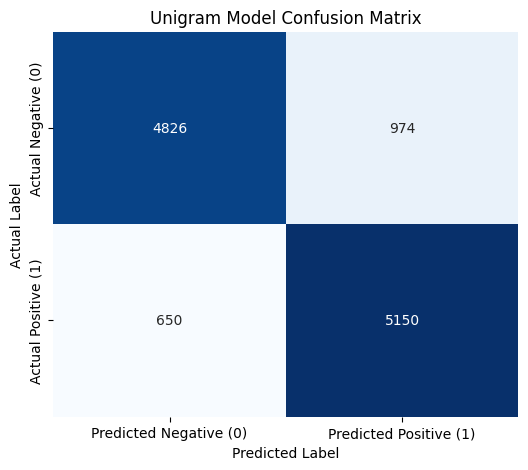

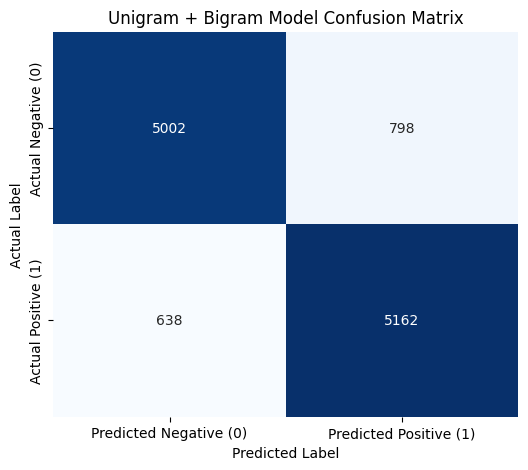

In [25]:
plot_confusion_matrix(y_test, y_pred_uni, title="Unigram Model Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_bi, title="Unigram + Bigram Model Confusion Matrix")

## 12. Cross-Validation

To ensure our model evaluation is robust, we'll implement k-fold cross-validation.

In [26]:
# -- k-fold cross-validation on the Naive Bayes --
def cross_validate_naive_bayes(X, y, vocab, k=5, alpha=1.0, use_bigrams=False):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    for train_idx, test_idx in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        if use_bigrams:
            X_train_bow = [text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=True) for tokens in X_train_fold]
            X_test_bow = [text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=True) for tokens in X_test_fold]
        else:
            X_train_bow = [text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=False) for tokens in X_train_fold]
            X_test_bow = [text_to_bow(tokens, vocab, use_unigrams=True, use_bigrams=False) for tokens in X_test_fold]
        
        # train
        nb = NaiveBayes(alpha=alpha)
        nb.fit(X_train_bow, y_train_fold, vocab)
        y_pred = nb.predict(X_test_bow)
        
        # calculate metrics
        metrics['accuracy'].append(calculate_accuracy(y_test_fold, y_pred))
        metrics['precision'].append(calculate_precision(y_test_fold, y_pred))
        metrics['recall'].append(calculate_recall(y_test_fold, y_pred))
        metrics['f1_score'].append(calculate_f1_score(y_test_fold, y_pred))
    
    # calculate average metrics
    avg_metrics = {
        'accuracy': sum(metrics['accuracy']) / k,
        'precision': sum(metrics['precision']) / k,
        'recall': sum(metrics['recall']) / k,
        'f1_score': sum(metrics['f1_score']) / k
    }
    
    return avg_metrics

In [27]:
print("Running 5-fold cross-validation for Unigram model...")
cv_metrics_uni = cross_validate_naive_bayes(X, y, unigram_vocab, k=5, alpha=1.0, use_bigrams=False)


print("\nRunning 5-fold cross-validation for Unigram+Bigram model...")
cv_metrics_bi = cross_validate_naive_bayes(X, y, bigram_vocab, k=5, alpha=1.0, use_bigrams=True)

# results
print("\nCross-Validation Results (Average over 5 folds):")
print(f"{'=' * 60}")
print(f"Metric          | Unigram Model | Unigram+Bigram Model")
print(f"{'-' * 60}")
print(f"Accuracy        | {cv_metrics_uni['accuracy']:.2f}%      | {cv_metrics_bi['accuracy']:.2f}%      ")
print(f"Precision       | {cv_metrics_uni['precision']:.2f}%      | {cv_metrics_bi['precision']:.2f}%      ")
print(f"Recall          | {cv_metrics_uni['recall']:.2f}%      | {cv_metrics_bi['recall']:.2f}%      ")
print(f"F1 Score        | {cv_metrics_uni['f1_score']:.2f}%      | {cv_metrics_bi['f1_score']:.2f}%      ")
print(f"{'=' * 60}")

Running 5-fold cross-validation for Unigram model...
Naive Bayes training complete.
Log Priors: {0: -0.6941821987651603, 1: -0.6921132325098809}
Log Likelihood for Unknown Words: {0: -13.134777996137103, 1: -12.943406553542248}
Naive Bayes training complete.
Log Priors: {0: -0.6969907645709756, 1: -0.6893183131405567}
Log Likelihood for Unknown Words: {0: -13.137963067072032, 1: -12.948326606797911}
Naive Bayes training complete.
Log Priors: {0: -0.693233391172525, 1: -0.6930609773789945}
Log Likelihood for Unknown Words: {0: -13.141671764937097, 1: -12.943322832200314}
Naive Bayes training complete.
Log Priors: {0: -0.6893183131405567, 1: -0.6969907645709756}
Log Likelihood for Unknown Words: {0: -13.145229933524043, 1: -12.940532100403592}
Naive Bayes training complete.
Log Priors: {0: -0.6920271184086436, 1: -0.694268498657339}
Log Likelihood for Unknown Words: {0: -13.137707058752333, 1: -12.93830591479732}

Running 5-fold cross-validation for Unigram+Bigram model...
Naive Bayes tr

## 10. Results Summary

Let's compare the performance metrics of both model variations using both single split and cross-validation methods.

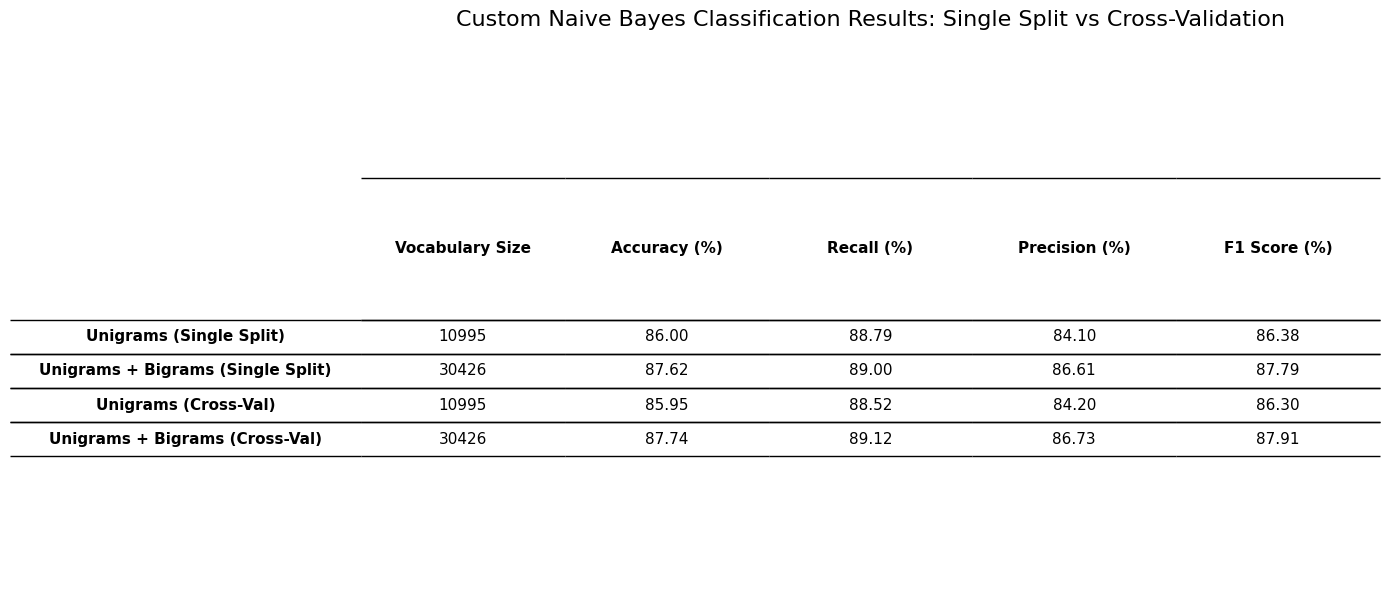


Summary:
- Single Split: The Unigrams + Bigrams model outperformed the Unigrams model (F1 Score: 87.79% vs 86.38%)
  F1 Score improvement: 1.41%
- Cross-Validation: The Unigrams + Bigrams model also outperformed the Unigrams model (Avg F1 Score: 87.91% vs 86.30%)
  Average F1 Score improvement: 1.60%

Cross-validation confirms that adding bigrams provides consistent improvement in classification performance.


In [28]:
models = ['Unigrams (Single Split)', 'Unigrams + Bigrams (Single Split)', 'Unigrams (Cross-Val)', 'Unigrams + Bigrams (Cross-Val)']

results = {
    'Vocabulary Size': [len(unigram_vocab), len(bigram_vocab), len(unigram_vocab), len(bigram_vocab)],
    'Accuracy (%)': [
        metrics_uni['accuracy'], 
        metrics_bi['accuracy'],
        cv_metrics_uni['accuracy'],
        cv_metrics_bi['accuracy']
    ],
    'Recall (%)': [
        metrics_uni['recall'], 
        metrics_bi['recall'],
        cv_metrics_uni['recall'],
        cv_metrics_bi['recall']
    ],
    'Precision (%)': [
        metrics_uni['precision'], 
        metrics_bi['precision'],
        cv_metrics_uni['precision'],
        cv_metrics_bi['precision']
    ],
    'F1 Score (%)': [
        metrics_uni['f1_score'], 
        metrics_bi['f1_score'],
        cv_metrics_uni['f1_score'],
        cv_metrics_bi['f1_score']
    ]
}


df_results = pd.DataFrame(results, index=models)
df_formatted = df_results.round(2).copy()  # round for readability

# percentage columns % symbol
percentage_columns = ['Accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 Score (%)']
for col in percentage_columns:
    df_formatted[col] = df_formatted[col].apply(lambda x: f"{x:.2f}")

# plot
plt.figure(figsize=(14, 6))
plt.title("Custom Naive Bayes Classification Results: Single Split vs Cross-Validation", fontsize=16, pad=20)
plt.box(on=None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

colors = np.zeros_like(df_results.values, dtype=object)

colors[0:2, :] = '#F0F8FF'  # Light blue for single 
colors[2:4, :] = '#F0FFF0'  # Light green for cross-validation
COLOR_GREEN = '#D5F5E3'  # Highlight green

for i in range(1, df_results.shape[1]):  # exclude vocabulary size
    # single
    if df_results.iloc[0, i] > df_results.iloc[1, i]:  # unigram
        colors[0, i] = COLOR_GREEN
    else:  # bigram
        colors[1, i] = COLOR_GREEN
        
    # cross-validation
    if df_results.iloc[2, i] > df_results.iloc[3, i]:  # unigram 
        colors[2, i] = COLOR_GREEN
    else:  # bigram
        colors[3, i] = COLOR_GREEN

# for vocabulary size smaller is better
if df_results.iloc[0, 0] < df_results.iloc[1, 0]:  # unigram vocabulary 
    colors[0, 0] = COLOR_GREEN
    colors[2, 0] = COLOR_GREEN
else:  # bigram vocabulary
    colors[1, 0] = COLOR_GREEN
    colors[3, 0] = COLOR_GREEN

the_table = plt.table(
    cellText=df_formatted.values,
    rowLabels=df_formatted.index,
    colLabels=df_formatted.columns,
    loc='center',
    cellLoc='center',
    cellColours=colors,
    rowLoc='center',
    colLoc='center',
    edges='horizontal'
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(11)
for (row, col), cell in the_table.get_celld().items():
    # Bold headers
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold')
    if row == 0:
        cell.set_height(0.15)
    if col == -1:
        cell.set_width(0.25)

the_table.scale(1, 1.8)
plt.tight_layout()
plt.show()

# print summary 
print("\nSummary:")
f1_improvement_single = df_results.iloc[1, 4] - df_results.iloc[0, 4]
f1_improvement_cv = df_results.iloc[3, 4] - df_results.iloc[2, 4]
print(f"- Single Split: The Unigrams + Bigrams model outperformed the Unigrams model (F1 Score: {df_results.iloc[1, 4]:.2f}% vs {df_results.iloc[0, 4]:.2f}%)")
print(f"  F1 Score improvement: {f1_improvement_single:.2f}%")
print(f"- Cross-Validation: The Unigrams + Bigrams model also outperformed the Unigrams model (Avg F1 Score: {df_results.iloc[3, 4]:.2f}% vs {df_results.iloc[2, 4]:.2f}%)")
print(f"  Average F1 Score improvement: {f1_improvement_cv:.2f}%")
print("\nCross-validation confirms that adding bigrams provides consistent improvement in classification performance.")

## 11. Conclusion

In this assignment, we successfully implemented a Multinomial Naive Bayes classifier and a Bag-of-Words feature extraction mechanism from scratch, adhering to the constraint of minimal library usage.

**Process Summary:**
1.  **Data Loading & Exploration:** Loaded the Amazon reviews dataset, handled missing values, and examined its basic properties and rating distribution.
2.  **Binary Conversion:** Transformed the 5-star rating system into a binary sentiment classification task (Positive/Negative), excluding neutral 3-star reviews.
3.  **Custom Preprocessing:** Implemented basic text cleaning (lowercase, remove non-alpha, remove digits, remove custom stopwords, split) without relying on external NLP libraries.
4.  **Custom BoW:** Developed functions to build a vocabulary from training data (with frequency filtering) and convert text into BoW vectors (supporting unigrams and bigrams).
5.  **Custom Naive Bayes:** Built a Naive Bayes classifier using log probabilities and Laplace smoothing (alpha=1.0) to handle numerical stability and unseen words.
6.  **Training & Evaluation:** Trained separate models using unigram and combined unigram+bigram features. Evaluated performance using custom-implemented metrics (Accuracy, Precision, Recall, F1 Score) on a single train-test split (80/20).
7.  **Cross-Validation:** Implemented 5-fold cross-validation to provide a more robust estimate of model performance.

**Key Findings:**
- The custom Naive Bayes implementation successfully classified Amazon reviews. The best performance was achieved using **Unigram + Bigram features**, yielding an **F1 Score of 87.79%** on the single test set and an average **F1 Score of 87.91%** across 5-fold cross-validation.
- Including bigrams alongside unigrams resulted in a **1.41% improvement in F1 score** on the single test split and a **1.60% average improvement** in cross-validation compared to using only unigrams. This confirms that word pairs provide valuable contextual information for sentiment prediction in this dataset.
- We observed that negative reviews tend to have slightly more tokens after preprocessing (average of **22.11 tokens**) compared to positive reviews (average of **18.04 tokens**), suggesting customers might write more when expressing dissatisfaction.
- The Unigram+Bigram model achieved better precision (**86.61%** single split, **86.73%** CV avg) compared to the Unigram model (**84.10%** single split, **84.20%** CV avg), indicating fewer false positives when classifying positive reviews.
- The word clouds revealed distinct vocabulary differences between positive and negative reviews, with positive reviews featuring words like "great", "love", and "perfect", while negative reviews contained words like "waste", "broken", and "disappointed".

**Potential Improvements:**
- Experiment with different `min_freq` thresholds for vocabulary building.
- Implement trigrams or character n-grams in the BoW representation.
- Refine the preprocessing step, perhaps using domain-specific stop words or lemmatization/stemming (though this might require external libraries).
- Add feature weighting using TF-IDF instead of raw counts.
- Analyze the most informative features (words/n-grams with highest log likelihood differences between classes).
- Tune the Laplace smoothing parameter `alpha`.

This project demonstrates the effectiveness of the Naive Bayes algorithm for text classification even with a relatively simple custom implementation. The consistent improvement observed when adding bigrams, both in the single split and cross-validation, highlights the importance of considering word context in sentiment analysis tasks.

### References

- [Stop Words List - GitHub](https://gist.github.com/sebleier/554280) - Acces Date: 23/04/2025
- [Custom Naive Bayes - GitHub](https://github.com/gbroques/naive-bayes) - Acces Date: 23/04/2025
- [Custom Naive Bayes - GeeksforGeeks](https://www.geeksforgeeks.org/ml-naive-bayes-scratch-implementation-using-python/) - Acces Date: 23/04/2025

# Bonus Section: Comparing with NLTK Preprocessing and Word Embeddings

In this bonus section, we will explore how using more advanced preprocessing techniques (NLTK) and different feature representations (Word Embeddings) affect the classification performance compared to our custom BoW and Naive Bayes implementation.

We will compare three approaches:
1.  **Custom BoW + Custom NB (Unigram+Bigram):** The best model from the main assignment.
2.  **NLTK BoW + Custom NB:** Using NLTK for preprocessing (tokenization, stop words, stemming) but still using our custom BoW and Naive Bayes.
3.  **Word2Vec + Logistic Regression:** Using Word2Vec embeddings as features and a standard Logistic Regression classifier from scikit-learn.

In [ ]:
# Import additional libraries for the bonus section
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
import warnings

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\berke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\berke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Bonus 1: BoW with NLTK Preprocessing

Applying NLTK preprocessing...
Sample NLTK preprocessed tokens:
3097                                 [smell, smell, good, bit, strong, dont, spray, much, tri, spray, cloth, rather, skin, cant, say, sure, work, im, yet, see, anyth, special, alreadi, abl, give, star, smell]
6758                                                                                                                                                               [would, purchas, like, way, make, hair, feel]
36510    [comfort, sound, great, batteri, life, definit, short, advertis, typic, troubl, earbud, style, alway, tough, time, get, stay, ear, hesit, tri, figur, worth, shot, ran, day, get, nervou, issu, stay...
23402                   [case, macbook, jiggl, around, like, least, larger, width, macbook, qualiti, great, like, case, soft, interior, keep, size, correctli, advertis, size, worri, knock, around, side, much]
5042                                                                                                

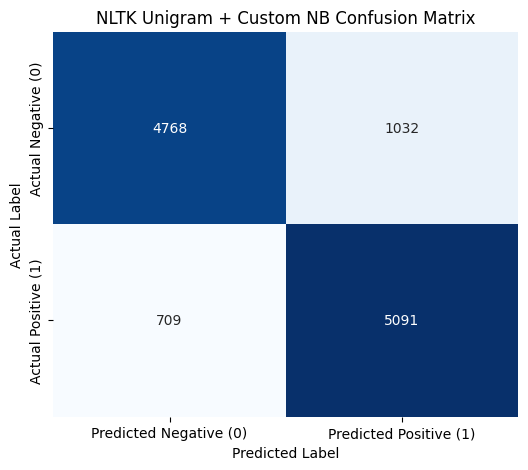

In [30]:
# NLTK Preprocessing Function
stemmer = PorterStemmer()
nltk_stopwords = set(stopwords.words('english'))

def preprocess_text_nltk(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # only letters and spaces
    tokens = word_tokenize(text)
    
    # remove stopwords and apply stemming
    processed_tokens = [
        stemmer.stem(word) for word in tokens 
        if word not in nltk_stopwords and len(word) > 1
    ]
    return processed_tokens

print("Applying NLTK preprocessing...")
binary_df['tokens_nltk'] = binary_df['full_text'].apply(preprocess_text_nltk)

X_nltk = binary_df.loc[X_train_tokens.index.union(X_test_tokens.index), 'tokens_nltk']
y_nltk = binary_df.loc[X_train_tokens.index.union(X_test_tokens.index), 'sentiment']

X_train_tokens_nltk, X_test_tokens_nltk, y_train_nltk, y_test_nltk = train_test_split(
    X_nltk, y_nltk, test_size=0.2, random_state=42, stratify=y_nltk
)

print("Sample NLTK preprocessed tokens:")
print(X_train_tokens_nltk.head())

print("\n--- Processing NLTK Unigrams ---")
nltk_unigram_vocab = build_vocabulary(X_train_tokens_nltk, min_freq=3)
X_train_bow_nltk = [text_to_bow(tokens, nltk_unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_train_tokens_nltk]
X_test_bow_nltk = [text_to_bow(tokens, nltk_unigram_vocab, use_unigrams=True, use_bigrams=False) for tokens in X_test_tokens_nltk]

# Custom Naive Bayes with NLTK BoW features
print("\n--- Training NLTK Unigram Naive Bayes ---")
nb_nltk = NaiveBayes(alpha=1.0)
nb_nltk.fit(X_train_bow_nltk, y_train_nltk, nltk_unigram_vocab)

print("\n--- Evaluating NLTK Unigram Naive Bayes ---")
y_pred_nltk = nb_nltk.predict(X_test_bow_nltk)
metrics_nltk = show_metrics(y_test_nltk, y_pred_nltk, "NLTK Unigram + Custom NB")
plot_confusion_matrix(y_test_nltk, y_pred_nltk, title="NLTK Unigram + Custom NB Confusion Matrix")

## Bonus 2: Word Embeddings (Word2Vec) + Logistic Regression

In [31]:
# Train Word2Vec model
print("Training Word2Vec model...")
word2vec_model = Word2Vec(
    sentences=X_train_tokens_nltk, 
    vector_size=100,
    window=5,
    min_count=3,  # min frequency 
    workers=4
)
print(f"Word2Vec vocabulary size: {len(word2vec_model.wv.index_to_key)}")



Training Word2Vec model...
Word2Vec vocabulary size: 7450

Creating document vectors...
Shape of training vectors: (46400, 100)
Shape of test vectors: (11600, 100)


In [ ]:
# --- Create Document Vectors by averaging word vectors ---
def document_vector(tokens, model):
    tokens_in_vocab = [word for word in tokens if word in model.wv.index_to_key]
    if not tokens_in_vocab:  # no words
        return np.zeros(model.vector_size)
    return np.mean(model.wv[tokens_in_vocab], axis=0)

print("\nCreating document vectors...")
X_train_vectors = np.array([document_vector(tokens, word2vec_model) for tokens in X_train_tokens_nltk])
X_test_vectors = np.array([document_vector(tokens, word2vec_model) for tokens in X_test_tokens_nltk])

print(f"Shape of training vectors: {X_train_vectors.shape}")
print(f"Shape of test vectors: {X_test_vectors.shape}")


--- Training Logistic Regression with Word2Vec Features ---

--- Evaluating Logistic Regression ---

Performance Metrics: Word2Vec + Logistic Regression
--------------------------------------------------
Accuracy:  84.43%
Precision: 85.53%
Recall:    82.88%
F1 Score:  84.19%


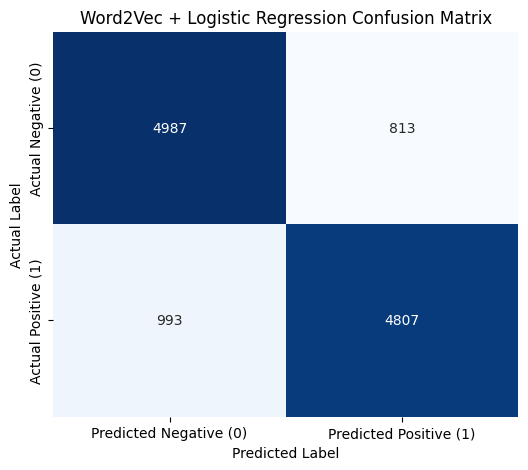

In [32]:
print("\n--- Training Logistic Regression with Word2Vec Features ---")
log_reg = LogisticRegression(random_state=42, max_iter=1000) # higher max_iter for convergence
log_reg.fit(X_train_vectors, y_train_nltk)

print("\n--- Evaluating Logistic Regression ---")
y_pred_log_reg = log_reg.predict(X_test_vectors)

metrics_log_reg = show_metrics(y_test_nltk, y_pred_log_reg, "Word2Vec + Logistic Regression")
plot_confusion_matrix(y_test_nltk, y_pred_log_reg, title="Word2Vec + Logistic Regression Confusion Matrix")

## Bonus 3: Comparison and Conclusion


--- Bonus Section Results Comparison ---


,Feature Type,Classifier,Vocabulary/Vector Size,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
Custom BoW + NB (Uni+Bi),Custom BoW (Uni+Bi),Custom NB,30426,87.62,86.61,89.00,87.79
NLTK BoW + Custom NB (Uni),NLTK BoW (Uni),Custom NB,7450,84.99,83.15,87.78,85.40
Word2Vec + LogReg,Word2Vec,Logistic Regression,100,84.43,85.53,82.88,84.19


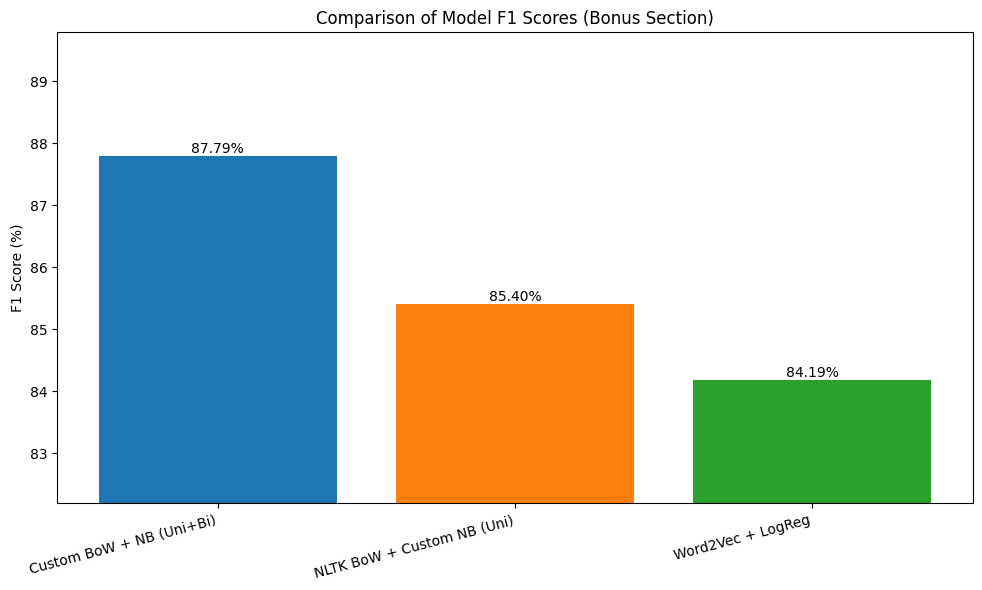

In [33]:
# Combine results for comparison
bonus_models = [
    'Custom BoW + NB (Uni+Bi)', 
    'NLTK BoW + Custom NB (Uni)', 
    'Word2Vec + LogReg'
]

bonus_results = {
    'Feature Type': ['Custom BoW (Uni+Bi)', 'NLTK BoW (Uni)', 'Word2Vec'],
    'Classifier': ['Custom NB', 'Custom NB', 'Logistic Regression'],
    'Vocabulary/Vector Size': [len(bigram_vocab), len(nltk_unigram_vocab), word2vec_model.vector_size],
    'Accuracy (%)': [metrics_bi['accuracy'], metrics_nltk['accuracy'], metrics_log_reg['accuracy']],
    'Precision (%)': [metrics_bi['precision'], metrics_nltk['precision'], metrics_log_reg['precision']],
    'Recall (%)': [metrics_bi['recall'], metrics_nltk['recall'], metrics_log_reg['recall']],
    'F1 Score (%)': [metrics_bi['f1_score'], metrics_nltk['f1_score'], metrics_log_reg['f1_score']]
}

df_bonus_results = pd.DataFrame(bonus_results, index=bonus_models)
df_bonus_formatted = df_bonus_results.round(2).copy()

# Format percentage columns
percentage_columns_bonus = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
for col in percentage_columns_bonus:
    df_bonus_formatted[col] = df_bonus_formatted[col].apply(lambda x: f"{x:.2f}")

print("\n--- Bonus Section Results Comparison ---")
print(df_bonus_formatted)

# f1 scores for comparions
plt.figure(figsize=(10, 6))
f1_scores = df_bonus_results['F1 Score (%)']
bars = plt.bar(df_bonus_results.index, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('F1 Score (%)')
plt.title('Comparison of Model F1 Scores (Bonus Section)')
plt.xticks(rotation=15, ha='right')
plt.ylim(bottom=max(0, f1_scores.min() - 2), top=f1_scores.max() + 2) # Adjust y-axis limits slightly

# add f1 scores value 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center', fontsize=10) # Adjust text position and size

plt.tight_layout()
plt.show()

**Bonus Conclusion:**

This bonus section compared our best custom model (Custom BoW with Unigrams+Bigrams and Custom Naive Bayes) against two alternatives using external libraries:
1.  **NLTK BoW + Custom NB:** Using NLTK for preprocessing (tokenization, stopword removal, Porter stemming) with our custom BoW (unigrams only for this test) and Naive Bayes.
2.  **Word2Vec + Logistic Regression:** Using Word2Vec word embeddings (trained on NLTK-processed data, averaged to create document vectors) and a standard Logistic Regression classifier from scikit-learn.

**Observations:**

-   **Performance Ranking:** Based on the F1 Score on the single test split:
    1.  **Custom BoW + NB (Uni+Bi): 87.79%**
    2.  NLTK BoW + Custom NB (Uni): 85.40%
    3.  Word2Vec + LogReg: 84.19%

-   **Custom Implementation Superiority:** Surprisingly, our best custom model (using custom preprocessing and including bigrams) outperformed both alternatives tested in the bonus section. This suggests that for this specific dataset and task, our tailored preprocessing and the inclusion of bigrams were more effective than the standard NLTK preprocessing (with stemming) or the simple averaging approach used for Word2Vec.
-   **NLTK Preprocessing Impact:** Using NLTK's preprocessing (stemming, default stopwords) resulted in a noticeable drop in performance (F1 Score: 85.40%) compared to our best custom model (87.79%). This might indicate that stemming was too aggressive, conflating important words, or that our custom stopword list was more suitable. The NLTK model also used only unigrams, which likely contributed to the lower score compared to our unigram+bigram model.
-   **Word Embeddings Performance:** The Word2Vec + Logistic Regression approach performed the worst in this comparison (F1 Score: 84.19%). While Word2Vec captures semantic meaning, simply averaging word vectors to create a document representation is a basic technique and might lose too much information. More sophisticated methods for utilizing word embeddings (e.g., TF-IDF weighted averaging, using RNNs/LSTMs) or further hyperparameter tuning (vector size, window, min_count for Word2Vec; regularization for LogReg) might be necessary to achieve better results.
-   **Trade-offs:** The bonus approaches required external libraries (NLTK, Gensim, Scikit-learn) and involved potentially more complex steps (training embeddings, hyperparameter tuning). In this instance, the simpler custom BoW approach yielded the best results.

In summary, while leveraging standard NLP libraries and embeddings is often beneficial, this bonus comparison highlights that a well-tuned custom approach, even if simpler, can sometimes outperform more complex methods, especially if the standard techniques (like basic document vector averaging) are not optimally applied or if the custom preprocessing is particularly well-suited to the data.